## Lab 1 Pathfinding
Pathfinding is about getting from location A to location B. In this tutorial, we’ll create an Euclidean maze, which is a two-dimensional grid of cells.

In the maze, we can only move in four directions to the immediately neighboring cells. We will need to navigate from a start point to an end point.

## Maze configuration
A maze is represented as a two-dimensional grid of cells, for example:

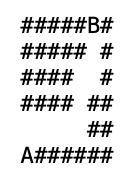

In the maze configuration above:


*   'A' cell is the start cell
*   'B' cell is the destination cell
*   '#' cells are wall and could not move to the cells
*   ' ' cells are avaiable to move in

Three example of maze configurations are in maze1.txt, maze2.txt and maze3.txt files.

## Solution representation
Solution is a path from the start point ('A' cell) to the end point ('B' cell).
This path is represented by '*' cells, for example:


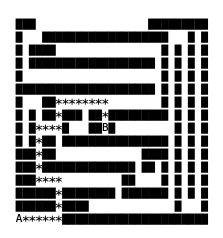

In the above example, '█' are wall cells and ' ' are cells with out wall.
A solution with the details is also illustrated using an image, for example:

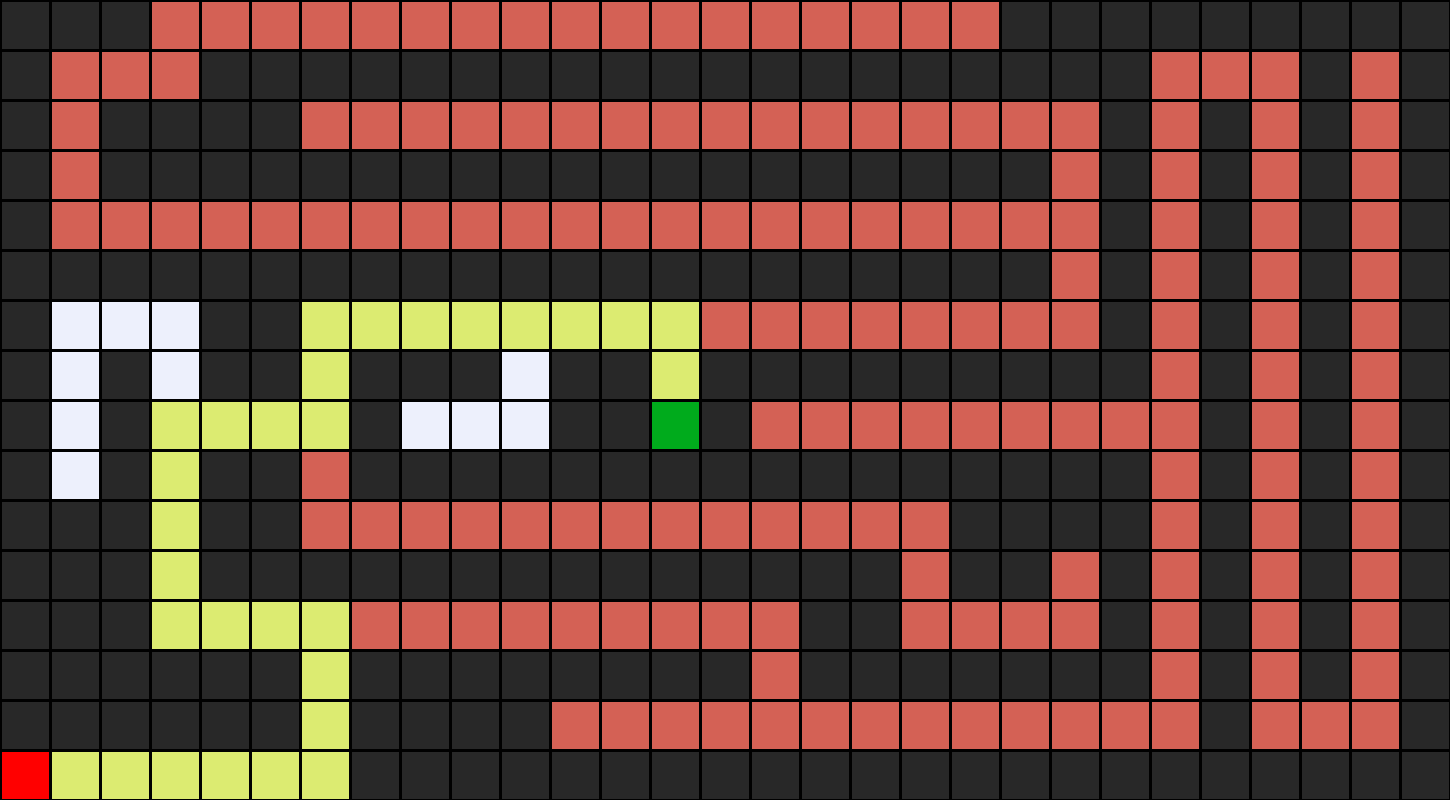

In the image above:

*   Red and green cells denote the start and end points
*   Dark gray cells denote the wall cells
*   Yellow cells denote the found path from the start point to the end point
*   Coral cells denote the explored cells during the process of finding the path
*   White cells denote unexplored cells during the process of finding the path





## Questions
You are asked to implement different search algorithms to find a solution to the maze, if one exists. The algorithms are:


1.   DFS
2.   BFS
3.   Greedy best-first seach
4.   A* search

DFS is imlemented as an example. You should investigate the code and other utility classes and methods to get some advices on implementing other search algorithms.



## Node and StackFrontier class
The following code defines Node class and StackFrontier class.

The Node data structure includes:

*   state: coordinate of the node - cell (rowIndex, colIndex) in the maze
*   parent: the explored node in the previous action
*   action: the performed action to move from the parent node to the current node. An action can be 'up', 'down', 'left', and 'right'
* cost: the cost to reach this node from the start cell (you will need this information when implementing A* algorithm)

Figure below shows an example of node data structure:








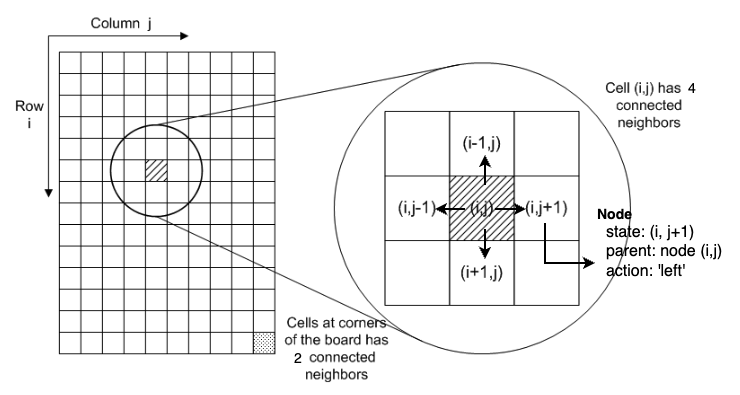

The StackFrontier data structure includes:
*   __init__(): creates an empty stack frontier
*   add(): adds a node to the frontier
*   contains_state(): returns True if a node state is in the frontier. Otherwise the method returns False.
*   empty(): returns True if the frontier is empty, otherwise returns False.
*   remove(): takes a node from the stack frontier

In [1]:
class Node():
  def __init__(self, state, parent, action, cost):
    self.state = state
    self.parent = parent
    self.action = action
    self.cost = cost

class StackFrontier():
  def __init__(self):
    self.frontier = []

  def add(self, node):
    self.frontier.append(node)

  def contains_state(self, state):
    return any(node.state == state for node in self.frontier)

  def empty(self):
    return len(self.frontier) == 0

  def remove(self):
    if self.empty():
      raise Exception("empty frontier")
    else:
      node = self.frontier[-1]
      self.frontier = self.frontier[:-1]
      return node


## Maze
Class Maze has the following methods:
*   __init__(): Read a configuration file and prepare data for the maze
*   print(): Print out the maze with the solution
*   output_image(): Export the maze with the solution's details to an image
*   neighbors(): Find all reachable cells from current state
*   solve(frontier): Solve the maze using an algorithm
    - StackFrontier: DFS algorithm
    - QueueFrontier: BFS algorithm
    - GBFSFrontier: Greedy best-first search algorithm
    - AStarFrontier: A* algorithm

In [2]:
class Maze():

  # Read a configuration file and prepare data for the maze
  def __init__(self, filename):
    # Read file and set height and width of maze
    with open(filename) as f:
      contents = f.read()

    # Validate start and goal
    if contents.count("A") != 1:
      raise Exception("maze must have exactly one start point")
    if contents.count("B") != 1:
      raise Exception("maze must have exactly one goal")

    # Determine height and width of maze
    contents = contents.splitlines()
    self.height = len(contents)
    self.width = max(len(line) for line in contents)

    # Keep track of walls and assign start and goal cells
    # walls[i][j] = True if ther is a wall at cell (i,j)
    # otherwise walls[i][j] = False
    self.walls = []
    for i in range(self.height):
      row = []
      for j in range(self.width):
        try:
          if contents[i][j] == "A":
            self.start = (i, j)
            row.append(False)
          elif contents[i][j] == "B":
            self.goal = (i, j)
            row.append(False)
          elif contents[i][j] == " ":
            row.append(False)
          else:
            row.append(True)
        except IndexError:
          row.append(False)
      self.walls.append(row)

    # Set solution to empty at the beginning
    self.solution = None

  # Print the maze with the solution
  # '*' cells are the path from A to B
  def print(self):
    solution = self.solution[1] if self.solution is not None else None
    print()
    for i, row in enumerate(self.walls):
      for j, col in enumerate(row):
        if col:
          print("█", end="")
        elif (i, j) == self.start:
          print("A", end="")
        elif (i, j) == self.goal:
          print("B", end="")
        elif solution is not None and (i, j) in solution:
          print("*", end="")
        else:
          print(" ", end="")
      print()
    print()

  # Export the maze with the solution's details to an image
  def output_image(self, filename, show_solution=True, show_explored=False):
    from PIL import Image, ImageDraw
    cell_size = 50
    cell_border = 2

    # Create a blank canvas
    img = Image.new(
      "RGBA",
      (self.width * cell_size, self.height * cell_size),
      "black"
    )
    draw = ImageDraw.Draw(img)

    solution = self.solution[1] if self.solution is not None else None
    for i, row in enumerate(self.walls):
      for j, col in enumerate(row):
        # Walls
        if col:
          fill = (40, 40, 40)

        # Start
        elif (i, j) == self.start:
          fill = (255, 0, 0)

        # Goal
        elif (i, j) == self.goal:
          fill = (0, 171, 28)

        # Solution
        elif solution is not None and show_solution and (i, j) in solution:
          fill = (220, 235, 113)

        # Explored
        elif solution is not None and show_explored and (i, j) in self.explored:
          fill = (212, 97, 85)

        # Empty cell
        else:
          fill = (237, 240, 252)

        # Draw cell
        draw.rectangle(
          ([(j * cell_size + cell_border, i * cell_size + cell_border),
          ((j + 1) * cell_size - cell_border, (i + 1) * cell_size - cell_border)]),
          fill=fill
        )

    img.save(filename)

  # Find all reachable cells from current state
  def neighbors(self, state):
    row, col = state
    candidates = [
      ("up", (row - 1, col)),
      ("down", (row + 1, col)),
      ("left", (row, col - 1)),
      ("right", (row, col + 1))
    ]

    result = []
    for action, (r, c) in candidates:
      if 0 <= r < self.height and 0 <= c < self.width and not self.walls[r][c]:
        result.append((action, (r, c)))
    return result

  def solve(self, frontier):
    """Finds a solution to maze, if one exists."""

    # Keep track of number of states explored
    self.num_explored = 0

    # Initialize frontier to just the starting position
    start = Node(state=self.start, parent=None, action=None, cost=0)
    frontier.add(start)

    # Initialize an empty explored set
    self.explored = set()

    # Keep looping until solution found
    while True:

      # If nothing left in frontier, then no path
      if frontier.empty():
        raise Exception("no solution")

      # Choose a node from the frontier
      node = frontier.remove()
      self.num_explored += 1

      # If node is the goal, then we have a solution
      if node.state == self.goal:
        actions = []
        cells = []
        while node.parent is not None:
          actions.append(node.action)
          cells.append(node.state)
          node = node.parent
        actions.reverse()
        cells.reverse()
        self.solution = (actions, cells)
        return

      # Mark node as explored
      self.explored.add(node.state)

      # Add neighbors to frontier
      for action, state in self.neighbors(node.state):
        if not frontier.contains_state(state) and state not in self.explored:
          child = Node(state=state, parent=node, action=action, cost=node.cost+1)
          frontier.add(child)



## QueueFrontier
In order to implement BFS, you need a QueueFrontier instead of StackFrontier.

In [3]:
class QueueFrontier():
  def __init__(self):
    self.frontier = []

  def add(self, node):
    self.frontier.append(node)

  def contains_state(self, state):
    return any(node.state == state for node in self.frontier)

  def empty(self):
    return len(self.frontier) == 0

  def remove(self):
    if self.empty():
      raise Exception("empty frontier")
    else:
      node = self.frontier[0]
      self.frontier = self.frontier[1:]
      return node


## GBFSFrontier
In order to implement Greedy Best-first search algorithm, you need a GBFSFrontier data structure.

In [4]:
class GBFSFrontier:

  def __init__(self, goal):
    self.frontier = []
    self.goal = goal

  def add(self, node):
    self.frontier.append(node)

  def contains_state(self, state):
    return any(node.state == state for node in self.frontier)

  def empty(self):
    return len(self.frontier) == 0

  def manhattanDistance(self, cell1, cell2):
    r1, c1 = cell1
    r2, c2 = cell2
    return abs(r2 - r1) + abs(c2 - c1)

  def heuristic(self, node):
    return self.manhattanDistance(node.state, self.goal)

  def findMin(self):
    indexMin = 0
    for index in range(len(self.frontier)):
      if self.heuristic(self.frontier[index]) < self.heuristic(self.frontier[indexMin]):
        indexMin = index
    return indexMin

  def remove(self):
    if self.empty():
      raise Exception("empty frontier")
    else:
      indexMin = self.findMin()
      node = self.frontier[indexMin]
      self.frontier.pop(indexMin)
      return node


## AStarFrontier
In order to implement A* search algorithm, you need a AStarFrontier data structure.

In [5]:
class AStarFrontier:

  def __init__(self, goal):
    self.frontier = []
    self.goal = goal

  def add(self, node):
    self.frontier.append(node)

  def contains_state(self, state):
    return any(node.state == state for node in self.frontier)

  def empty(self):
    return len(self.frontier) == 0

  def manhattanDistance(self, cell1, cell2):
    r1, c1 = cell1
    r2, c2 = cell2
    return abs(r2 - r1) + abs(c2 - c1)

  def heuristic(self, node):
    return node.cost + self.manhattanDistance(node.state, self.goal)

  def findMin(self):
    indexMin = 0
    for index in range(len(self.frontier)):
      if self.heuristic(self.frontier[index]) < self.heuristic(self.frontier[indexMin]):
        indexMin = index
    return indexMin

  def remove(self):
    if self.empty():
      raise Exception("empty frontier")
    else:
      indexMin = self.findMin()
      node = self.frontier[indexMin]
      self.frontier.pop(indexMin)
      return node


## Main program

### Load a maze configuration file

In [6]:
m = Maze("maze2.txt")
print("Maze:")
m.print()

Maze:

█ █    █   ██B█         █ █ █  
█ █ ██             ████ █ █ █  
███ ██             ████ █ █ █  
███ ████████████████ ██ █ █ █  
███             ██    █ █ █ █  
██████ ██████████ ███████ █ █ █
██████ ████             █   █  
A      ██████████████████████  



### Solve with DFS

In [7]:
print("Solving...")
m.solve(StackFrontier())
print("States Explored:", m.num_explored)
print("Solution:")
m.print()
m.output_image("maze_dfs.png", show_explored=True)

Solving...
States Explored: 62
Solution:

█ █****█   ██B█         █ █ █  
█ █*██********     ████ █ █ █  
███*██             ████ █ █ █  
███*████████████████ ██ █ █ █  
███****         ██    █ █ █ █  
██████*██████████ ███████ █ █ █
██████*████             █   █  
A******██████████████████████  



### Solve with BFS

In [8]:
print("Solving...")
m.solve(QueueFrontier())
print("States Explored:", m.num_explored)
print("Solution:")
m.print()
m.output_image("maze_bfs.png", show_explored=True)

Solving...
States Explored: 49
Solution:

█ █****█   ██B█         █ █ █  
█ █*██********     ████ █ █ █  
███*██             ████ █ █ █  
███*████████████████ ██ █ █ █  
███****         ██    █ █ █ █  
██████*██████████ ███████ █ █ █
██████*████             █   █  
A******██████████████████████  



### Solve with Greedy Best-first search

In [9]:
print("Solving...")
m.solve(GBFSFrontier(m.goal))
print("States Explored:", m.num_explored)
print("Solution:")
m.print()
m.output_image("maze_gbfs.png", show_explored=True)

Solving...
States Explored: 40
Solution:

█ █****█***██B█         █ █ █  
█ █*██*** ****     ████ █ █ █  
███*██             ████ █ █ █  
███*████████████████ ██ █ █ █  
███****         ██    █ █ █ █  
██████*██████████ ███████ █ █ █
██████*████             █   █  
A******██████████████████████  



### Solve with A*

In [10]:
print("Solving...")
m.solve(AStarFrontier(m.goal))
print("States Explored:", m.num_explored)
print("Solution:")
m.print()
m.output_image("maze_astar.png", show_explored=True)

Solving...
States Explored: 41
Solution:

█ █****█   ██B█         █ █ █  
█ █*██********     ████ █ █ █  
███*██             ████ █ █ █  
███*████████████████ ██ █ █ █  
███****         ██    █ █ █ █  
██████*██████████ ███████ █ █ █
██████*████             █   █  
A******██████████████████████  

